# Practical Bayesian Optimization of Machine Learning Algorithm

**Auteurs du projet**: Vincent LE MEUR, Thomas Levy,Timothée Watrigant

# Sources

L'article étudié est le suivant : https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf

Le code de l'implémentation est inspiré de : 
https://github.com/JasperSnoek/spearmint

# Introduction

Le choix des hyper-paramètres (ex : taux d'apprentissage, nombre de couches d'un réseau de neuronnes...) d'un modèle de Machine Learning peut être fastidieux et relève plus
souvent de l’expérience empirique que d'une méthode exacte. 

Cette optimisation peut être vue comme celle d'une fonction inconnue $f(x)$ qui évalue l'efficacité d'un algorithme avec des hyperparamètres $x$ fixés.

L'article propose un algorithme basé
sur l'optimisation bayésienne avec un prior Processus Gaussien (GP) pour automatiser le choix optimal des
hyper-paramètres. Cet algorithme a été appliqué et validé sur 3 problèmes de Machine Learning.

Nous allons décrire le principe de l'optimization Bayésienne, puis l'algorithme utilisé par les auteurs de l'étude. Enfin, nous essaierons de l'appliquer à un nouveau problème de
machine learning.

# 1) L'optimisation Bayésienne

L'idée est de considérer que la fonction inconnue $f(x)$ est issue d'un Prior et dont la distribution a posteriori reste cohérente avec ce Prior au fur et à mesure des observations. L'objectif est de trouver le minimum de cette fonction $f : \mathcal{X} \rightarrow \mathcal{R}$ où $\mathcal{X}$ désigne l'ensemble dans lequel évolue les hyperparamètres.

Dans notre cas précis, une observation correspond à faire tourner un algorithme de Machine Learning avec un ensemble d'hyperparamètres fixés et d'en évaluer l'efficacité.

L'optimisation bayésienne permet de choisir de manière "optimale" le prochain set d'hyperparamètres à tester. En effet, cette approche intégre l'incertitude sur la fonction $f$ de façon à la réduire lors de la prochaine évaluation. Ainsi comme dans beaucoup d'approches bayésiennes, l'ensemble de l'information des données est utilisée.

Pour pratiquer de l'optimisation bayésienne, il y a deux choix principaux à réaliser.
La premier choix est celui du <b>Prior</b> concernant la fonction $f$.
Le second choix est celui de la <b>fonction d'acquisition</b>. Cette dernière va servir à évaluer le prochain point à tester.

Les auteurs de l'article ont choisi comme prior un <b>Processus Gaussien</b> qui offre une excellente flexibilité sur la fonction $f$. Ainsi par définition, nos observations obtenues seront de la forme : $ \{ x_n,y_n\}$ avec $y_n \sim \mathcal{N}(f(x_n),\nu)$ avec $\nu$ la variance du bruit de mesure des observations.
Le support d'un tel processus peut se résumer avec deux fonctions : 
$m : \mathcal{X} \rightarrow \mathcal{R}$ la fonction moyenne, et $K : \mathcal{X} \times \mathcal{X} \rightarrow \mathcal{R} $ la fonction de covariance

La fonction d'acquisition quand à elle désigne une fonction $a : \mathcal{X} \rightarrow \mathcal{R}^+ $ qui nous permet de choisir le prochain point d'évaluation : $x_{next} = argmax_{\mathcal{X}}a(x)$. Ces fonctions dépendent des paramètres du Processus Gaussien ainsi que des précédentes observations. Plusieurs fonctions sont alors possibles comme "Probability of Improvment" qui maximise la probabilité d'avoir une "meilleure observation" par rapport à toutes les observations précédentes ou encore le "GP Upper Confidence Bound". Le choix des auteurs de l'article s'est porté sur l' <b>Expected Improvement $a_{EI}$</b>

Soit $\theta$ les hyperparamètres de notre GP, $\mu$ la fonction moyenne de prédiction et $\sigma$ la fonction de variance sous le prior GP (à ne pas confondre avec les fonctions $m$ et $K$ précédentes),$x_{best}=argmin_{x_1,..,x_n}f(x)$ la meilleure observation actuelle, $\gamma(x) = \dfrac{f(x_{best})-\mu(x; \{x_n,y_n\},\theta)}{\sigma(x;\{x_n,y_n\},\theta)}$ et $\Phi$ la fonction de répartition de la loi Normale alors l'Expected Improvment est définie par : 


$a_{EI}(x; \{x_n,y_n\},\theta) = \sigma(x; \{x_n,y_n\},\theta)(\gamma(x)\Phi(x) + \mathcal{N}(\gamma(x);1))$


Ce choix est justifié par de bonnes performances en minimisation et l'absence d'hyperparamètres supplémentaires.

# 2) Points clés de l'étude

Le travail réalisé dans ce contexte s'attaque à trois difficultés précises:
* La première est celle du choix de la fonction de covariance $K$ du GP qui peut être déterminant d'un problème à l'autre. 
* La deusième est la volonté de prendre en compte le temps d'évaluation de la fonction $f$ qui peut changer radicalement d'un problème à l'autre. En effet, on rappelle que l'évaluation de cette fonction implique la mise en place d'un algorithme de Machine Learning complet. 
* Enfin, malgré la nature séquentielle de cette optimisation bayésienne, les auteurs ont cherché à tirer profit de la parallélisation des calculs propres aux environnements distribués.

##  a) Le choix de la fonction de covariance

Le choix de cette fonction covariance peut induire d'importantes hypothèses sur la fonction $f$

Un choix courant est celui du "squared exponential kernel" (ou ARD). Néanmoins, les fonctions obtenues pour ce choix ont une régularité importante. Bien que cela soit positif d'un point de vue de l'optimisation, cela reste très peu réaliste pour l'optimisation complexe de notre fonction $f$.

C'est pourquoi les auteurs ont plutôt choisi comme fonction de covariance un choix plus "exotique", l'ARD Matérn 5/2 kernel :

$ K_{M52}(x,x') = \theta_0(1+ \sqrt{5r^2(x,x')} + \frac{5}{3}r^2(x,x'))e^{-\sqrt{5r^2(x,x')}} $
avec $ r^2(x,x')=\sum_{d=1}^D(x_d - x_d')^2/\theta^2_d$

On constate alors la présence de D+3 hyperparamètres issue de notre processus Gaussien (D est la dimension des vecteurs $x \in \mathcal{X}$) :
- D paramètres de longeurs d'échelles $\theta_{1:D}$
- $\theta_0$ l'amplitude de la covariance 
- $\nu$ le bruit de mesure et $m$ la moyenne

On concatène alors tous ces paramètres en un unique vecteur $\theta$

Il y a donc D+3 hyperparamètres à sélectionner. Pour avoir un traitement bayésien complet, l'idée des auteurs a été de modifier la fonction d'acquisition $a$ précédente en intégrant selon ce vecteur $\theta$. On obtient alors la fonction d'acquisition intégrée suivante : 

$â(x;\{x_n,y_n\}) = \int a(x:\{x_n,y_n\},\theta)p(\theta | \{x_n,y_n\}_{n=1}^N)d\theta $ 

avec $p(\theta | \{x_n,y_n\}_{n=1}^N)$ la distribution marginale issue des données et du processus Gaussien.

Il s'agit d'une généralisation permettant de prendre en compte l'incertitude sur le choix des hyperparamètres du GP.

## b) La prise en compte du temps d'évaluation

Bien que l'optimisation bayésienne précédente nous permette d'effectuer un choix optimal pour la prochaîne évaluation de f, cela peut se solder en pratique par un temps d'exécution très long (cela dépend fortement de la nature de l'espace des hyperparamètres $\mathcal{X}$). Cela rendrait donc l'étude non applicable en pratique avec des configurations machines classiques.

La fonction $f$ nous est inconnue tout comme la fonction $c : \mathcal{X} \rightarrow \mathcal{R}^+$ qui évalue le temps d'évaluation de la fonction $f$ au point $x$. 

Le point clé ici est d'utiliser toute la machinerie de notre optimisation bayésienne pour évaluer $ln$ $c(x)$ en plus de $f(x)$ en supposant que ces deux fonctions sont indépendantes l'une de l'autre.

Ainsi il est possible de tracer l'"expected improvement per second" en divisant par cette évaluation.

L'algorithme nous permet non seulement de choisir des points qui donneront une bonne optimisation de f mais également des points pour lesquels cette évaluation n'est pas trop couteuse en temps d'exécution.

## c) La parallélisation de l'optimisation Bayésienne par des acquisitions de Monte Carlo

Dans le cas où on veut paralléliser, il faut changer la fonction d’acquisition qui pourrait utiliser des roll-outs optimaux mais ils sont difficiles à mettre en place.

Ici, il est décidé d’utiliser une stratégie séquentielle, profitant des propriétés d’inférence des processus gaussiens. Cela permettra de calculer les estimations de Monte-Carlo de la fonction d’acquisition pour différents résultats possibles dépendants des fonctions d’évaluation en cours.

En ayant déjà N réalisations effectués (xn,yn) et J évaluations en cours (xi), on cherche à trouver un nouveau basé sur les N couples ainsi que toutes les sorties possibles d’évaluations en cours (yi). D’où l’intégration sur R pour les différents y. On parallélise sur le calcul de l’intégrale de la formule.

# 3) Implémentation 

PARTIE LINUX

Dans cette partie nous allons mettre en place une implémentation de cette optimisation.Nous allons appliquer un processus Gaussien avec le kernel ARD 5/2 et la fonction d'acquisition Expected Improvment.

Nous allons alors mettre en application cet algorithme d'optimisation sur un problème de classification multiclasse. Notre choix s'est porté vers le célèbre dataset iris. 

 Nous alors optimiser deux hyperparamètres pour deux algorithmes : SGDClassifier et SVC (basé sur des machines à vecteur support).
 
 Pour le SGDclassifier les deux hyperparamètres sont :
 - l1_ratio un paramètre d'élasticité
 - alpha, une constante de régularisation
 
Pour le SVC les deux hyperparamètres sont : 
- C, un terme de pénalité de la fonction d'erreur
- $\gamma$ coefficient propre au kernel utilisé

Nous allons enfin utiliser une fonction sklearn make_classification qui va nous générer un nouveau dataset sur lequel nous allons appliquer le SVC.

Pour cela, nous avons décidé d'utiliser des fonctions de sklearn pour la définition du kernel Mattern 5/2, et pour le processus gaussien. 

On commence par définir les fonctions utiles pour calculer l'optimisation bayésienne (kernel, expected improvment, détermination du prochain point d'application) puis des fonctions propres à l'affichage des figures.

Import des librairies :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn import datasets
from matplotlib import rc
%matplotlib inline

Définition de la fonction d'acquisition "Expected Improvement"

In [2]:
def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ 
        x: type array, point à calculer
        gaussian_process: Le processus gaussien entraîné précedemment sur les hyperparamètres    
        evaluated_loss: Numpy array contenant les valeurs de la fonction de perte précédemment évaluées
        greater_is_better: Boolean indiquant si il s'agit de maximiser ou minimiser la fonction de perte
        n_params: int indiquant la dimension des hyperparamètres

    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


Fonction déterminant le prochain point d'acquisition :

In [3]:
def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ 
        acquisition_func: fonction d'acquisition à optimiser
        gaussian_process: Le processus gaussien entraîné précedemment sur les hyperparamètres
        evaluated_loss: Numpy array contenant les valeurs de la fonction de perte précédemment évaluées
        greater_is_better: Boolean indiquant si il s'agit de maximiser ou minimiser la fonction de perte
        bounds: Tuple indiquant les limites de définition pour l'"optimiseur" L-BFGS
        n_restarts: int indiquant le nombre d'itération effectuées sur le minimiseur avec des valeurs différentes


    """
    # Initialisation : 
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))
        # Condition de changement d'hyperparamètres : 
        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x



Fonction optimisant la fonction de perte "sample_loss" à l'aide de processus Gaussien :

In [4]:
def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ 
        n_iters: int indiquant le nombre d'itérations à utiliser
        sample_loss: fonction à optimiser
        bounds: Array indiquant les bornes de la fonction de perte
        x0: array définissant des points initiaux où évaluer la fonction de perte. Si x0=None ces points sont choisis
        de manière aléatoire
        n_pre_samples: int indiquant le nombre de points initiaux si x0=None
        gp_params: dictionaire indiquant les hyperparamètres à passer au processus Gaussien.
        random_search: Boolean indiquant si on utilise une recherche aléatoire ou une optimisation L-BFGS sur la fonction
        d'acquisition
        alpha: double indiquant la variance associé au terme d'erreur du Processus Gaussien
        epsilon: double indiquant le niveau de tolérance pour l'évaluation des float

    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern(nu=5/2)
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Mise en place des hyperparamètres suivants : 
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Mise en place de la fonction de perte pour de nouveaux paramètres : 
        cv_score = sample_loss(next_sample)

        # Mise à jours des listes
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Mise à jour des sorties
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp


Les fonctions suivantes vont servir à créer des graphiques pour illustrer la mise en place de l'optimisation.
Les graphiques obtenus vont représenter en abscisse et ordonnées nos différents hyperparamètres avec un code couleur correspondant à des isovaleurs de la fonction de perte et de l'Expected Improovement respectivement : 

In [5]:
def plot_iteration(first_param_grid, sampled_params, sampled_loss, first_iter=0, alpha=1e-5,
                   greater_is_better=True, true_y=None, second_param_grid=None,
                   param_dims_to_plot=[0, 1], filepath=None, optimum=None):
    """ plot_iteration

    Plots a line plot (1D) or heatmap (2D) of the estimated loss function and expected
    improvement acquisition function for each iteration of the Bayesian search algorithm.

    Arguments:
    ----------
        first_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the first parameter.
        sampled_params: array-like, shape = [n_points, n_params]
            Points for which the value of the loss function is computed.
        sampled_loss: function.
            Values of the loss function for the parameters in `sampled_params`.
        first_iter: int.
            Only plot iterations after the `first_iter`-th iteration.
        alpha: float
            Variance of the error term in the GP model.
        greater_is_better: boolean
            Boolean indicating whether we want to maximise or minimise the loss function.
        true_y: array-like, shape = [n, 1] or None
            Array containing the true value of the loss function. If None, the real loss
            is not plotted. (1-dimensional case)
        second_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the second parameter, in case
            of a heatmap.
        param_dims_to_plot: list of length 2
            List containing the indices of `sampled_params` that contain the first and
            second parameter.
        optimum: array-like [1, n_params].
            Maximum value of the loss function.
    """

    # Create the GPMatern
    kernel = gp.kernels.Matern(nu=5/2)
    model = gp.GaussianProcessRegressor(kernel=kernel,
                                        alpha=alpha,
                                        n_restarts_optimizer=10,
                                        normalize_y=True)

    # Don't show the last iteration (next_sample is not available then)
    for i in range(first_iter, sampled_params.shape[0] - 1):
        model.fit(X=sampled_params[:(i + 1), :], y=sampled_loss[:(i + 1)])

        if second_param_grid is None:
            # 1-dimensional case: line plot
            mu, std = model.predict(first_param_grid[:, np.newaxis], return_std=True)
            ei = -1 * expected_improvement(first_param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=1)

            fig, ax1, ax2 = _plot_loss_1d(first_param_grid, sampled_params[:(i + 1), :], sampled_loss[:(i + 1)], mu, std, ei, sampled_params[i + 1, :], yerr=alpha, true_y=true_y)
        else:
            # Transform grids into vectors for EI evaluation
            param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

            mu, std = model.predict(param_grid, return_std=True)
            ei = -1 * expected_improvement(param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=2)

            fig, ax1, ax2 = _plot_loss_2d(first_param_grid, second_param_grid, sampled_params[:(i+1), param_dims_to_plot], sampled_loss, mu, ei, sampled_params[i + 1, param_dims_to_plot], optimum)

        if filepath is not None:
             plt.savefig('%s/bo_iteration_%d.png' % (filepath, i), bbox_inches='tight')


def _plot_loss_1d(x_grid, x_eval, y_eval, mu, std, ei, next_sample, yerr=0.0, true_y=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

    # Loss function plot
    ax1.plot(x_grid, mu, label = "GP mean")
    ax1.fill_between(x_grid, mu - std, mu + std, alpha=0.5)
    ax1.errorbar(x_eval, y_eval, yerr, fmt='ok', zorder=3, label="Observed values")
    ax1.set_ylabel("Function value f(x)")
    ax1.set_xlabel("x")

    if true_y is not None:
        ax1.plot(x_grid, true_y, '--', label="True function")

    # Acquisition function plot
    ax2.plot(x_grid, ei, 'r', label="Expected improvement")
    ax2.set_ylabel("Expected improvement (EI)")
    ax2.set_title("Next sample point is C = %.3f" % next_sample)
    ax2.axvline(next_sample)

    return fig, ax1, ax2

def _plot_loss_2d(first_param_grid, second_param_grid, sampled_params, sampled_loss, mu, ei, next_sample, optimum=None):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)

    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

    # EI contour plot
    cp = ax1.contourf(X, Y, ei.reshape(X.shape))
    plt.colorbar(cp, ax=ax1)
    ax1.set_title("Expected Improvement. Next sample will be (%.2f, %.2f)" % (next_sample[0], next_sample[1]))
    ax1.autoscale(False)
    ax1.axvline(next_sample[0], color='k')
    ax1.axhline(next_sample[1], color='k')
    ax1.scatter(next_sample[0], next_sample[1])
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("epsilon")

    # Loss contour plot
    cp2 = ax2.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=ax2)
    ax2.autoscale(False)
    ax2.scatter(sampled_params[:, 0], sampled_params[:, 1], zorder=1)
    ax2.axvline(next_sample[0], color='k')
    ax2.axhline(next_sample[1], color='k')
    ax2.scatter(next_sample[0], next_sample[1])
    ax2.set_title("Mean estimate of loss surface for iteration %d" % (sampled_params.shape[0]))
    ax2.set_xlabel("alpha")
    ax2.set_ylabel("epsilon")

    if optimum is not None:
        ax2.scatter(optimum[0], optimum[1], marker='*', c='red', s=150)

    return fig, ax1, ax2


## 1. SGDClassifier

Nous allons ici tenter d'optimiser les hyperparamètres de l'algorithme de classification de sklearn SGDClassifier

In [6]:
# Récupération des données
data,target = load_iris(True)
# On définit ici notre classifieur :
def sample_loss(params):
    return cross_val_score(SGDClassifier(alpha=10 **params[0], l1_ratio=params[1],loss='hinge'),
                           X=data, y=target, cv=3).mean()

On cherche une valeur optimale des hyperparamètres indiquée par une étoile rouge sur nos futurs graphs :

In [7]:
# Espace dans lequel va évoluer nos hyperparamètres
alphas = np.linspace(-4,2,100)
l1_ratios = np.linspace(0,1,100)

# On définit une matrice regroupant toutes les combinaisons des deux variables précédentes
param_grid = np.array([[alpha, l1_ratio] for alpha in alphas for l1_ratio in l1_ratios])

# On calcule la perte associée à ces hyperparamètres
real_loss = [sample_loss(params) for params in param_grid]

# On détermine les hyperparamètres "optimaux"
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([-3.57575758,  0.64646465])

On mets en place ci-dessous notre optimisation bayésienne : 

In [8]:
# On détermine l'espace dans lequel évolue nos paramètres
bounds = np.array([[-4,2], [0,1]])

# On lance notre algorithme d'optimisation
xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=1000)

On affiche les résultats obtenus par l'optimisation bayésienne pour la fonction de perte et l'Expected Improovement pour chaque itération : 

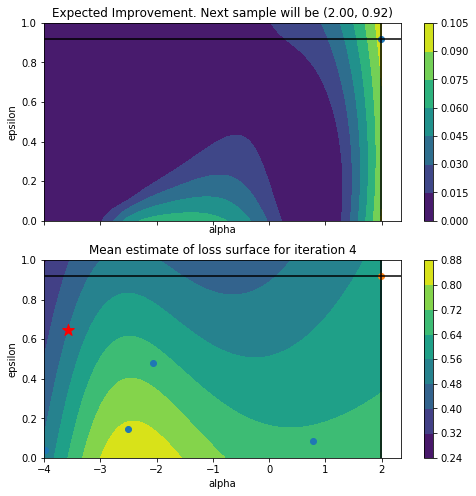

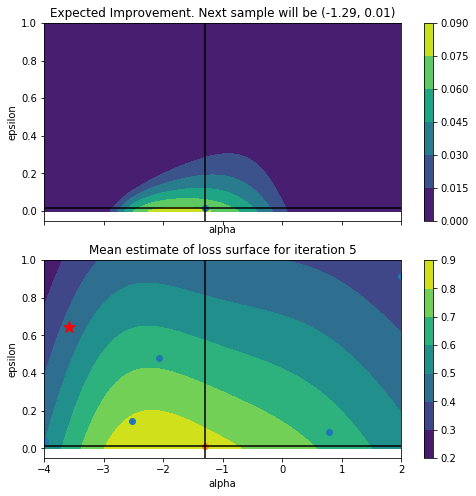

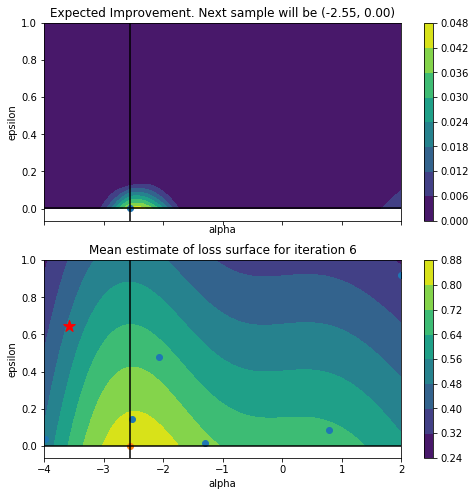

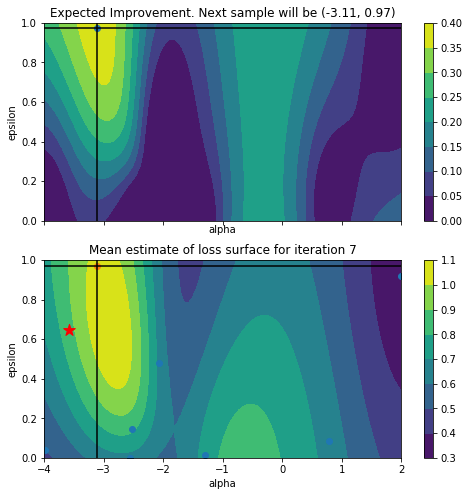

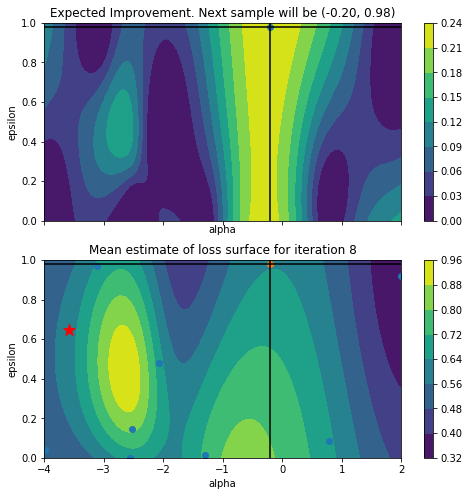

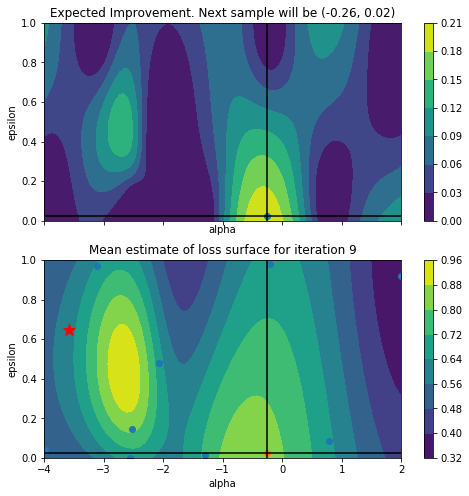

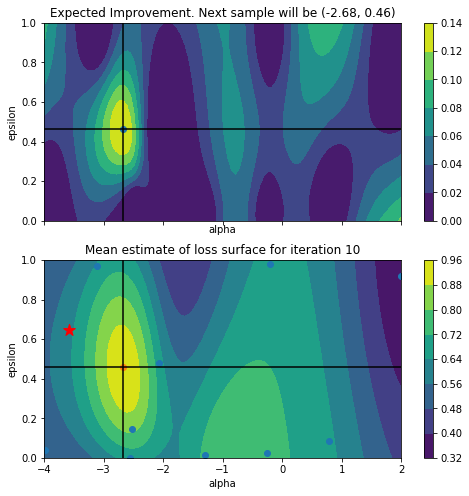

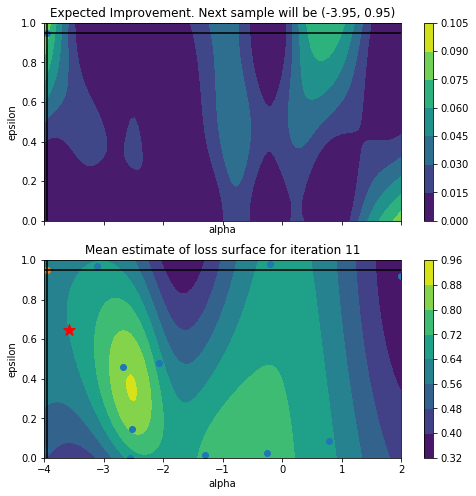

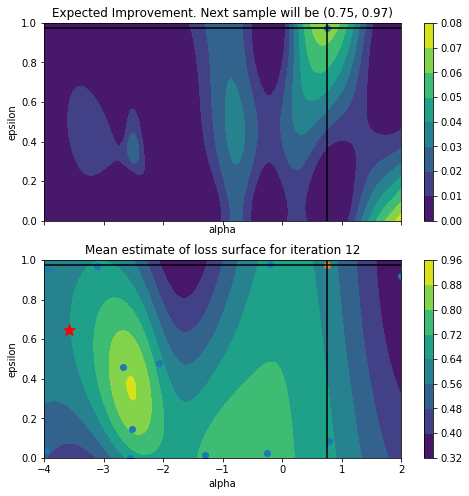

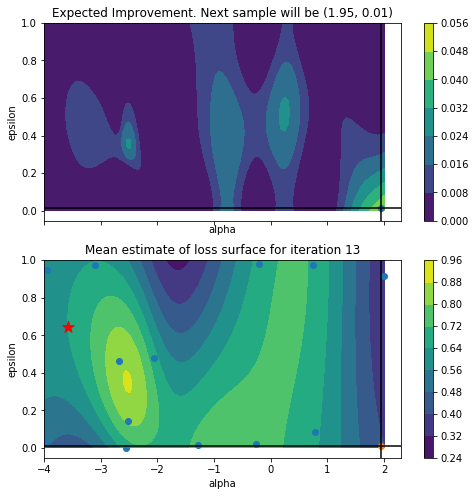

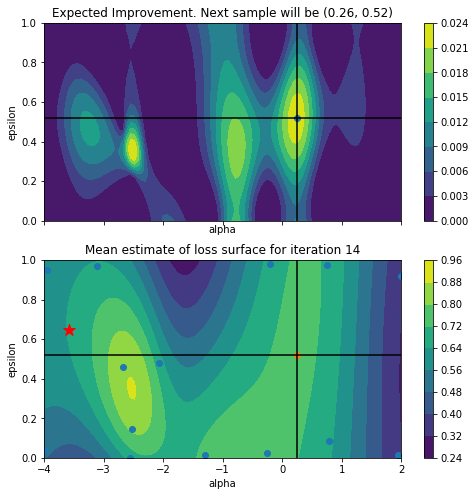

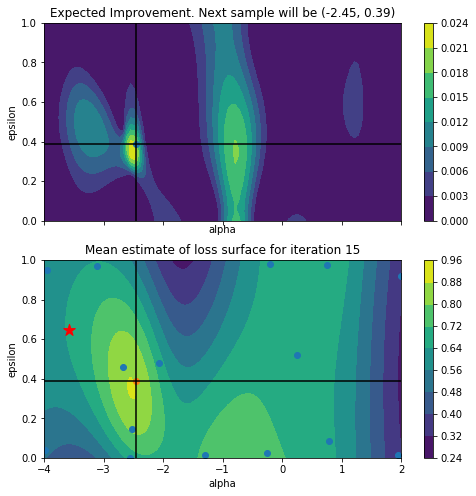

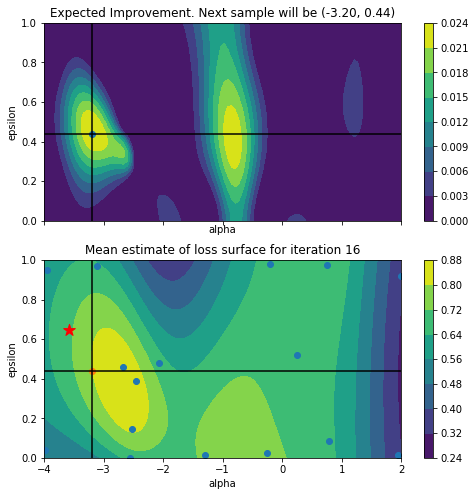

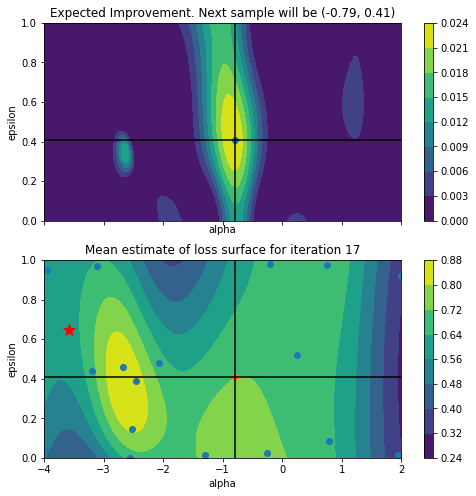

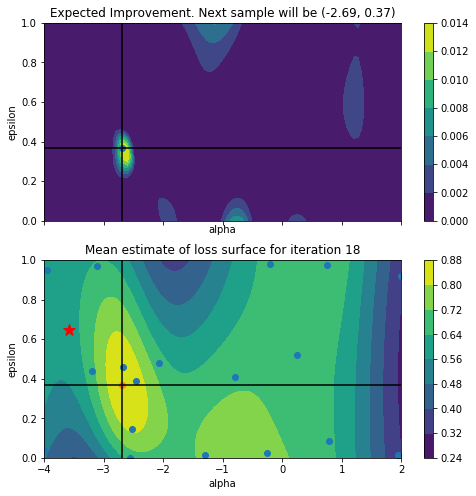

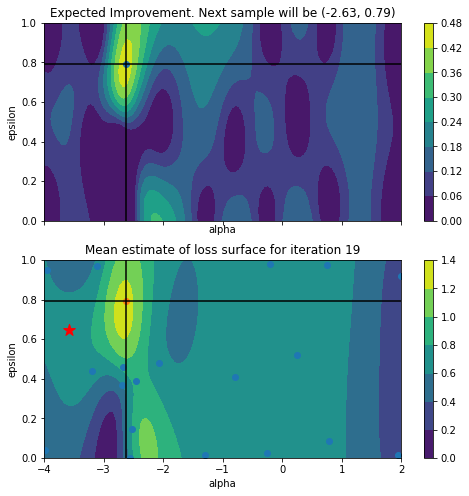

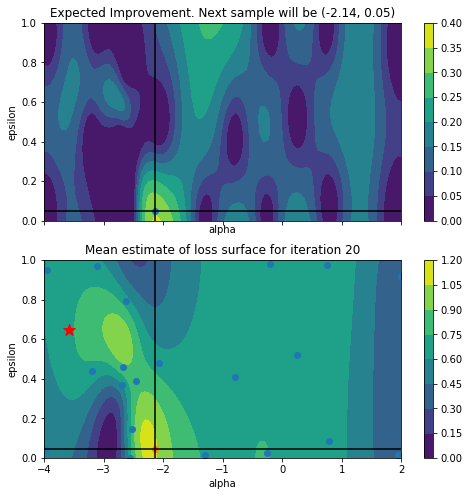

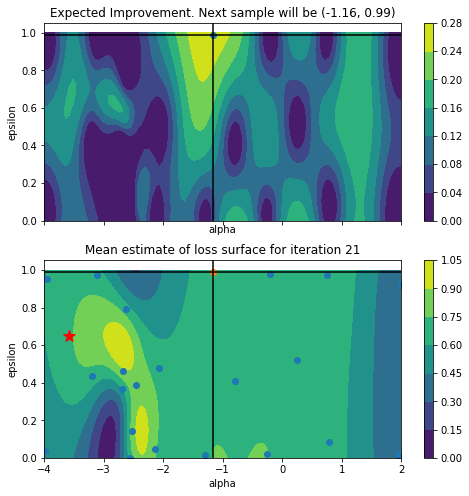

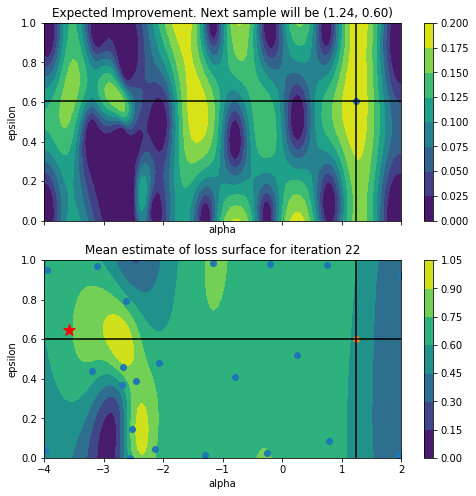

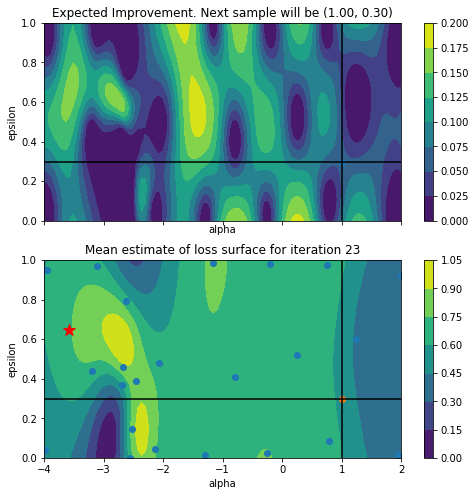

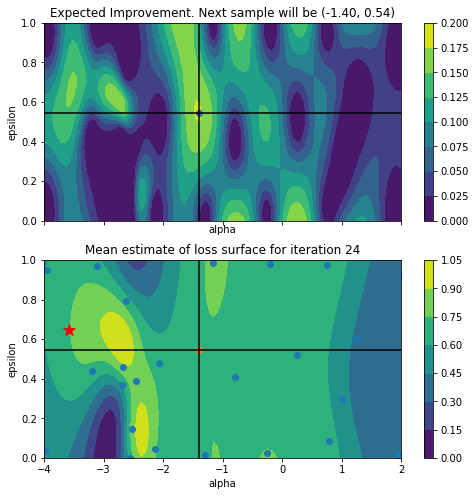

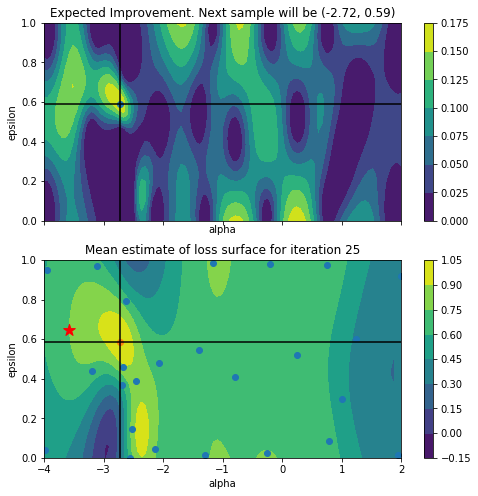

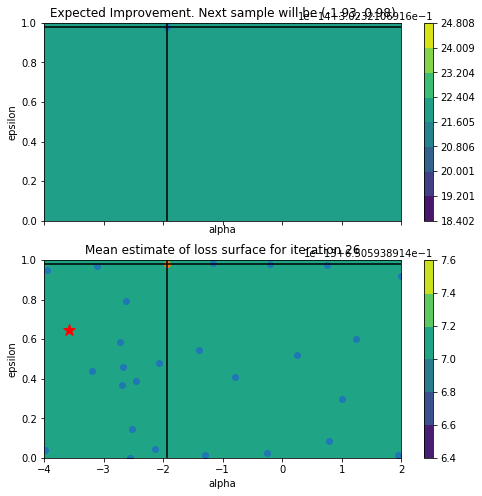

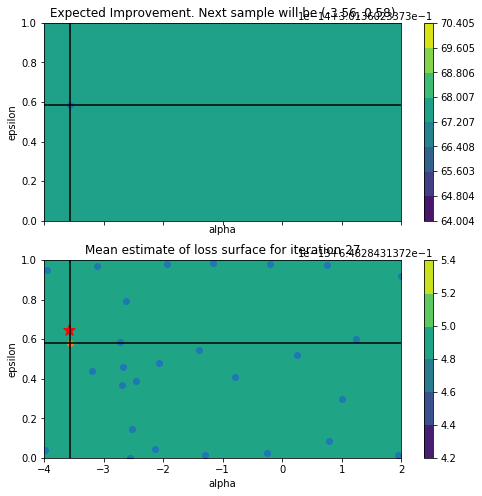

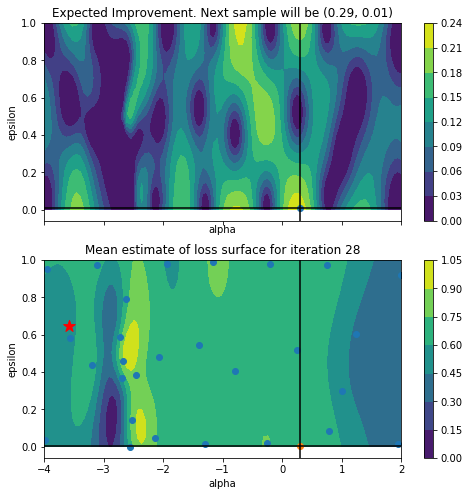

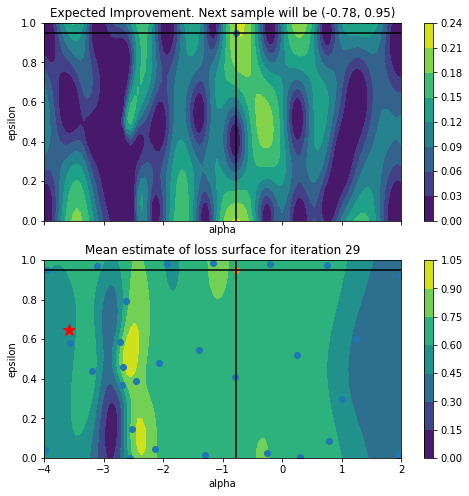

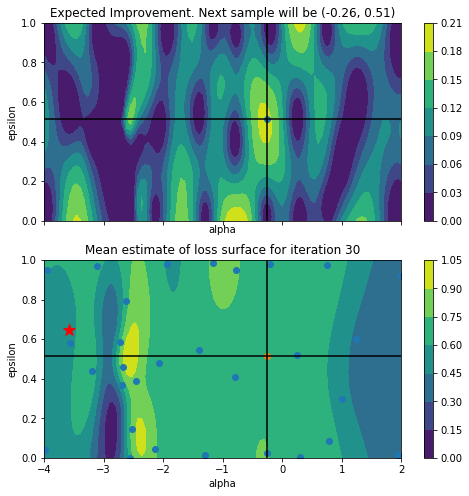

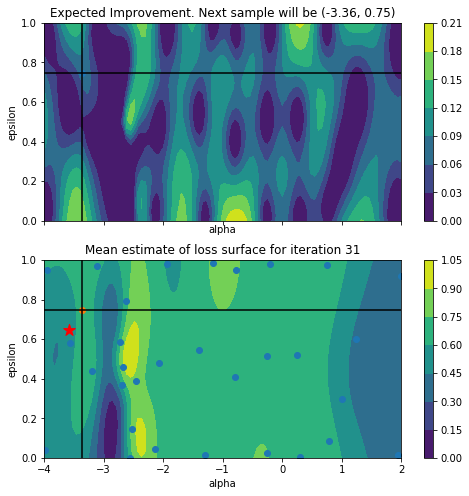

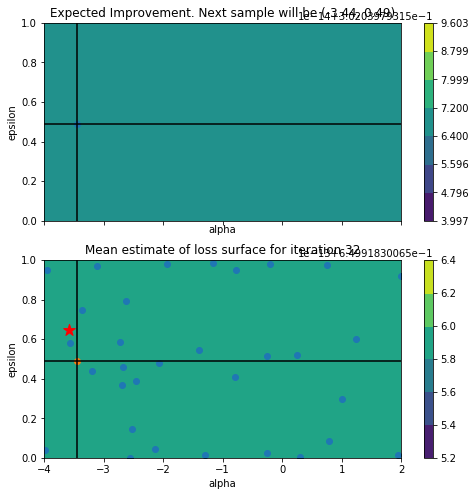

In [9]:
rc('text', usetex=False)
plot_iteration(alphas, xp, yp, first_iter=3, second_param_grid=l1_ratios, optimum=maximum, filepath='.')

On constate que l'algorithme ne tends pas vers le point optimal (étoile rouge) déterminé précedemment. Cependant, le point optimum obtenu lors des dernières itérations se trouve dans une zone iso-valeur plutôt faible ce qui nous conforte dans la convergence de l'algorithme vers des valeurs optimales.

## 2. SVM Classifier (SVC)

Appliquons à présent notre algorithme sur un autre modèle de classification : un SVC

In [10]:
def sample_loss2(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, cv=3).mean()

On cherche une valeur optimale des hyperparamètres indiquée par une étoile rouge sur nos futurs graphs :

In [11]:
# Espace dans lequel va évoluer nos hyperparamètres
Cs = np.linspace(5, -1, 25)
gammas = np.linspace(-1, -7, 20)

# On définit une matrice regroupant toutes les combinaisons des deux variables précédentes
param_grid = np.array([[C, gamma] for gamma in gammas for C in Cs])

# On calcule la perte associée à ces hyperparamètres
real_loss = [sample_loss2(params) for params in param_grid]

# On détermine les hyperparamètres "optimaux"
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([ 2.75      , -2.89473684])

On mets en place ci-dessous notre optimisation bayésienne : 

In [12]:
# On détermine l'espace dans lequel évolue nos paramètres
bounds = np.array([[-1, 5], [-7, -1]])

# On lance notre algorithme d'optimisation
xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss2, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

On affiche les résultats obtenus par l'optimisation bayésienne pour la fonction de perte et l'Expected Improovement pour chaque itération : 

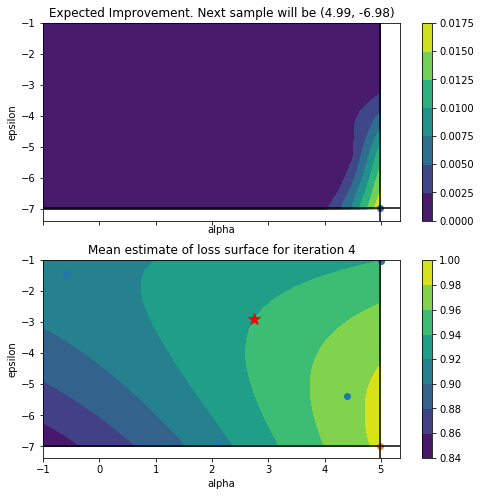

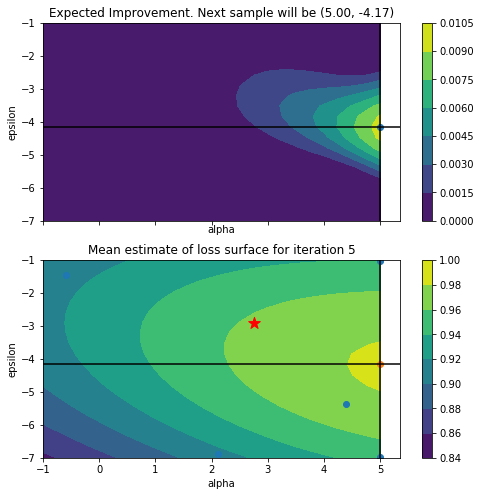

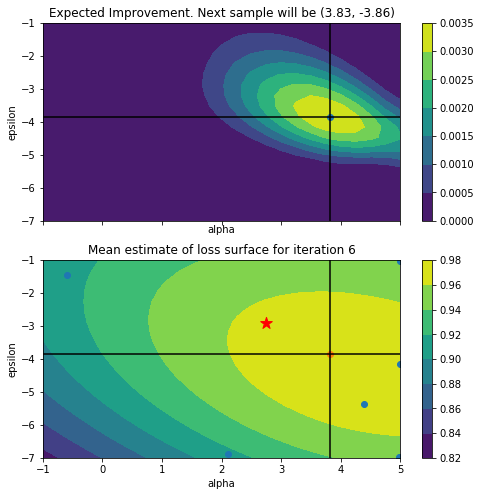

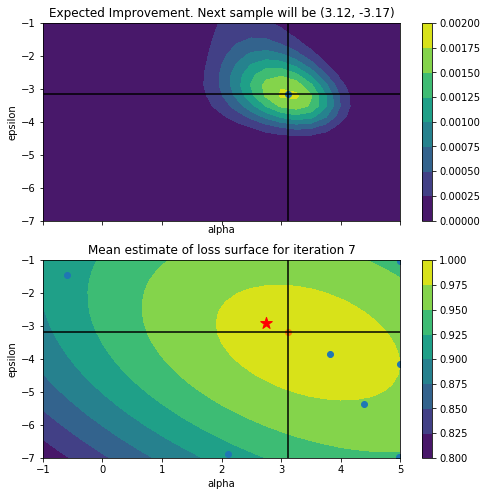

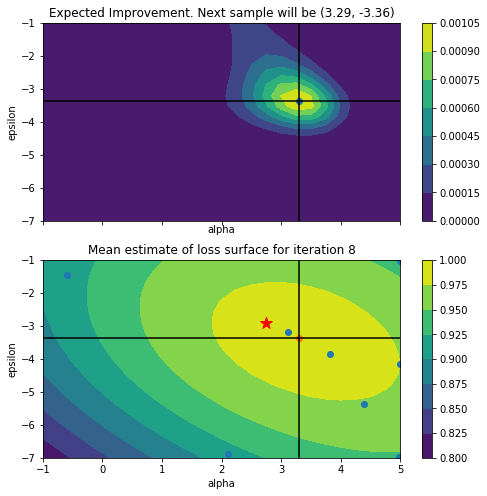

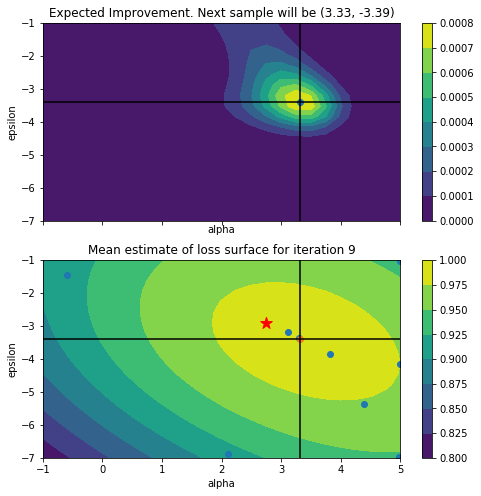

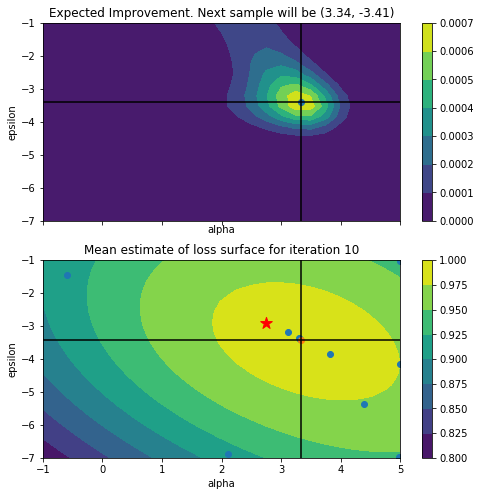

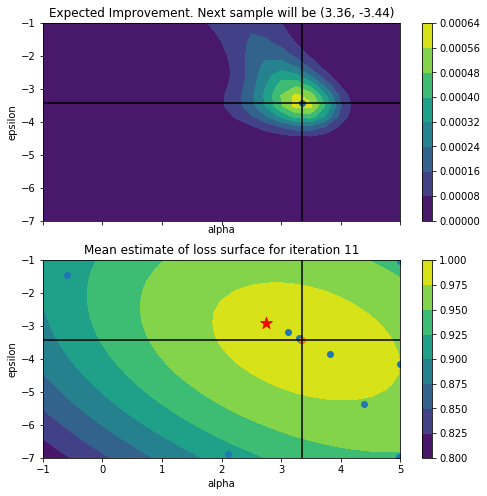

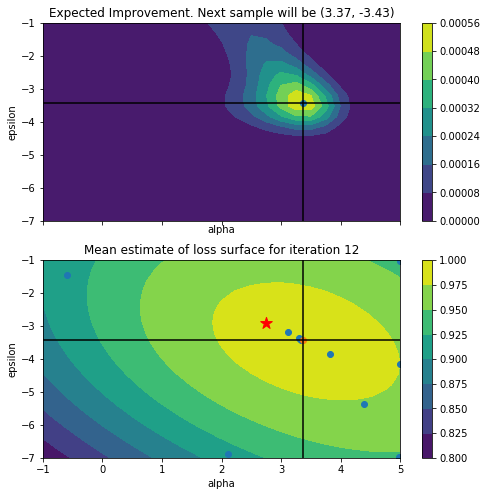

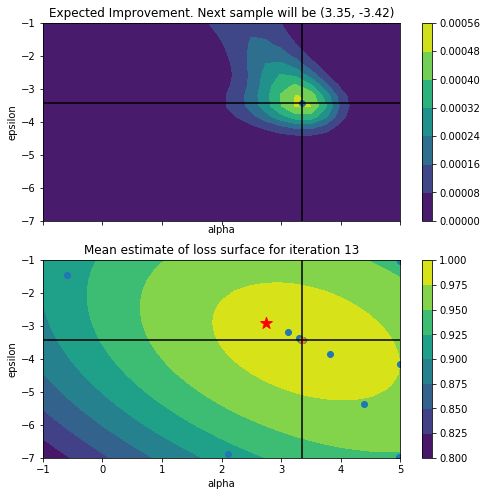

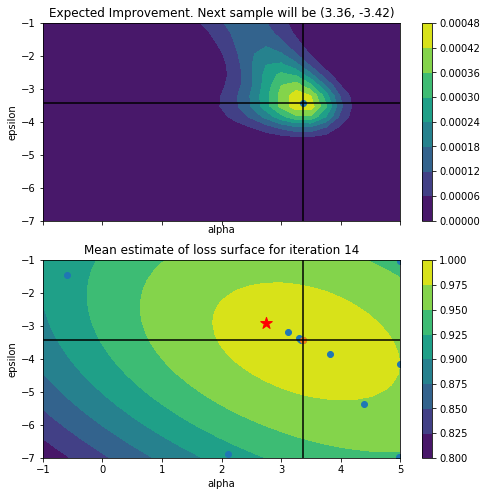

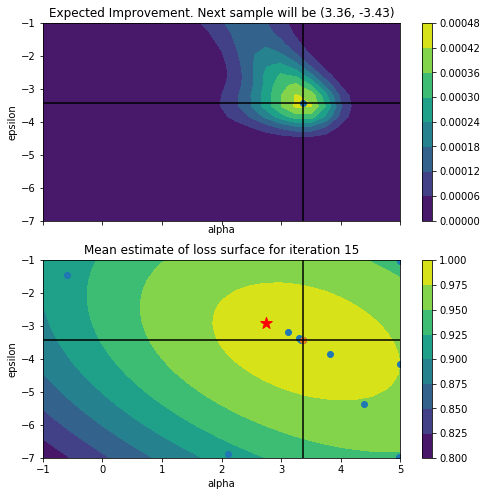

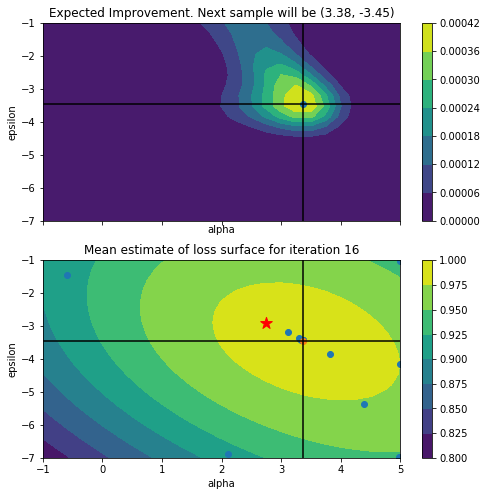

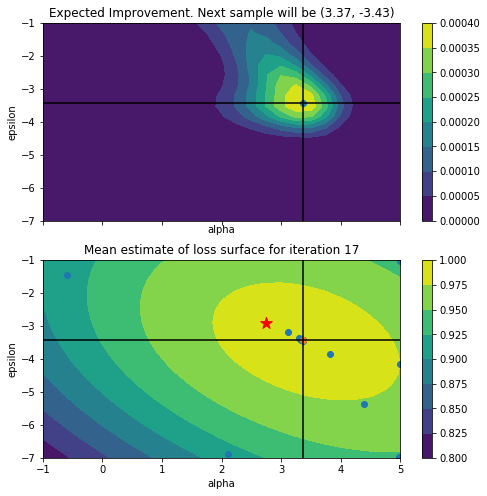

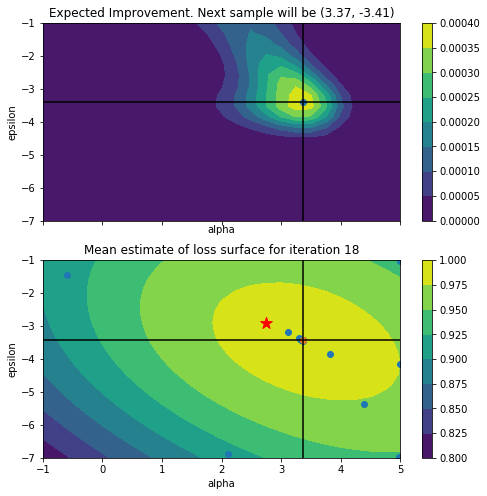

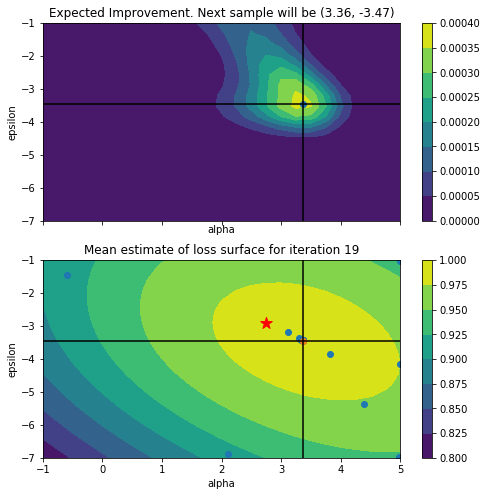

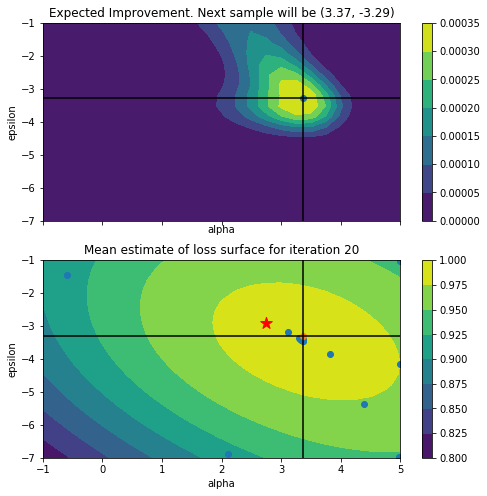

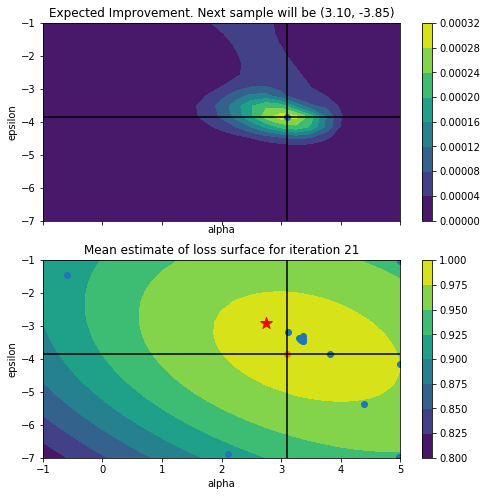

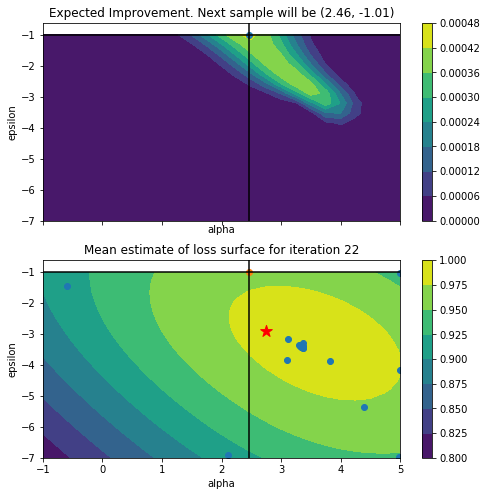

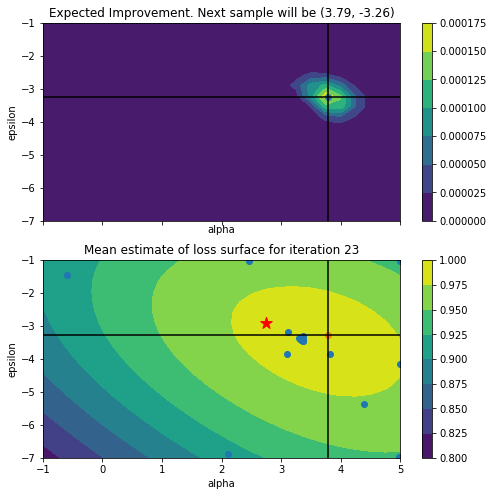

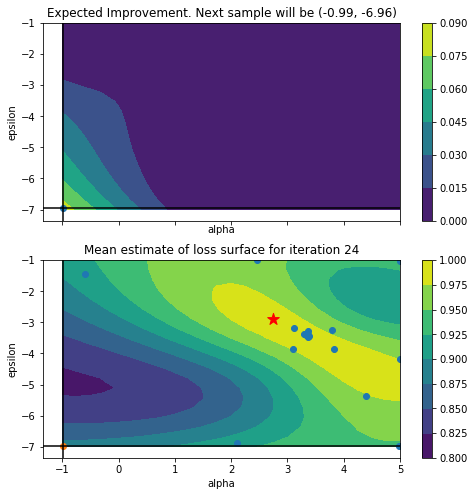

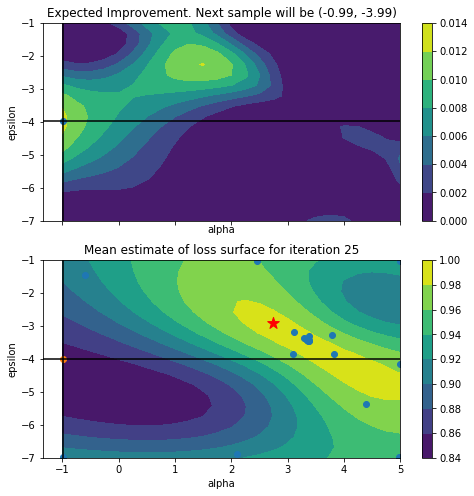

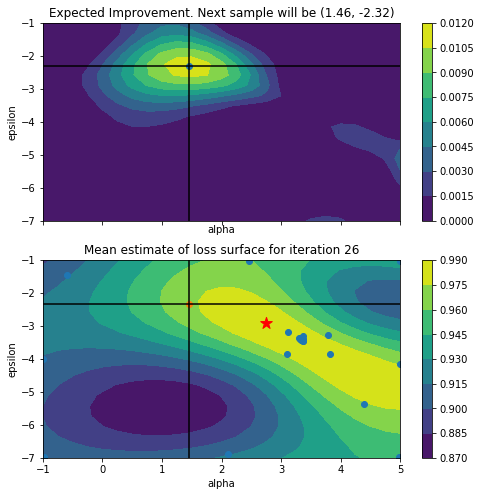

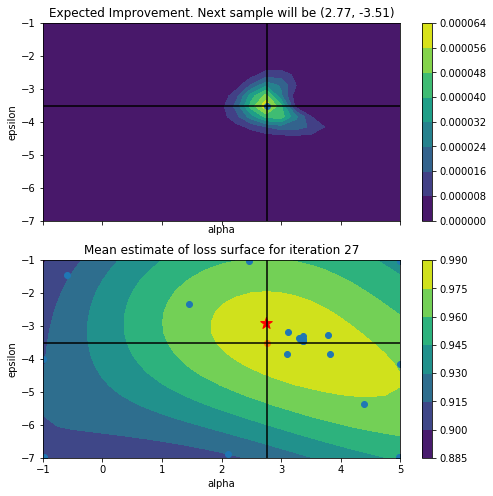

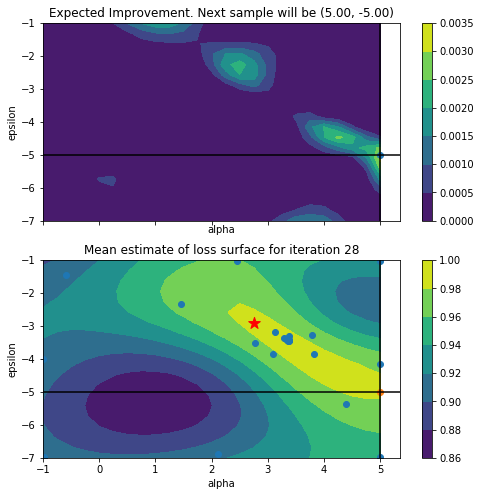

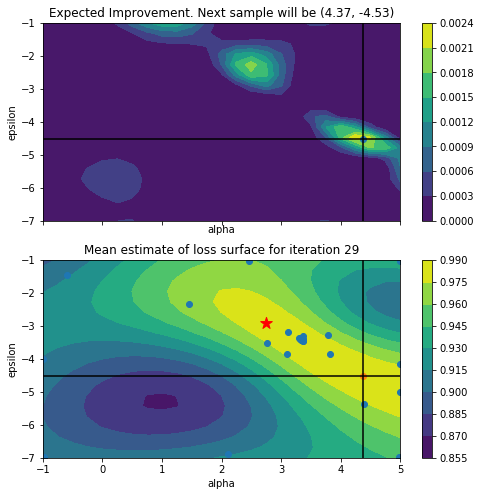

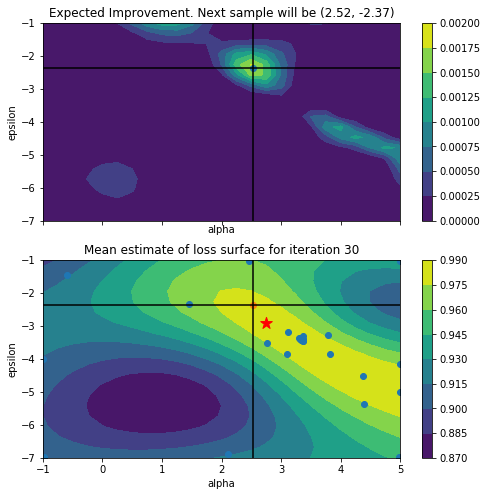

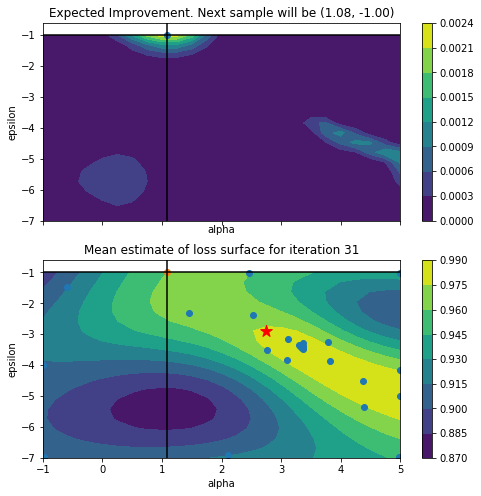

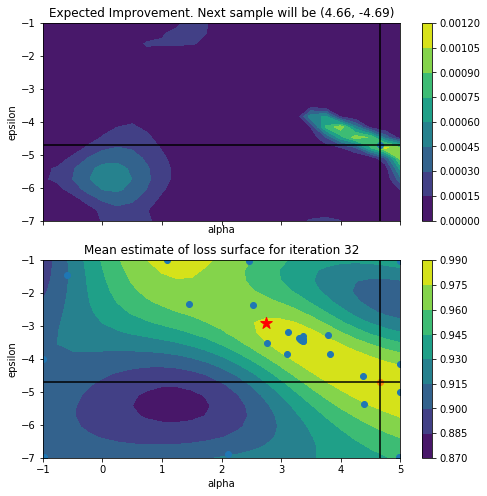

In [13]:
rc('text', usetex=False)

plot_iteration(Cs, xp, yp, first_iter=3, second_param_grid=gammas, optimum=maximum, filepath='.')


Ici encore, l'algorithme ne semble pas tendre vers notre valeur "optimale". Néanmoins la dernière itération se trouve sur une zone d'isovaleurs optimale.

## 3. Utilisation de make_classification

Nous générons ci-dessous notre nouveau dataset auquel nous allons appliquer l'algorithme précédent :

In [14]:
data, target = datasets.make_classification(n_samples=1000,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

In [15]:
# Espace dans lequel va évoluer nos hyperparamètres
Cs = np.linspace(5, -1, 25)
gammas = np.linspace(-1, -7, 20)

# On définit une matrice regroupant toutes les combinaisons des deux variables précédentes
param_grid = np.array([[C, gamma] for gamma in gammas for C in Cs])

# On calcule la perte associée à ces hyperparamètres
real_loss = [sample_loss2(params) for params in param_grid]

# On détermine les hyperparamètres "optimaux"
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([ 0.5       , -2.26315789])

In [16]:
# On détermine l'espace dans lequel évolue nos paramètres
bounds = np.array([[-1, 5], [-7, -1]])

# On lance notre algorithme d'optimisation
xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss2, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

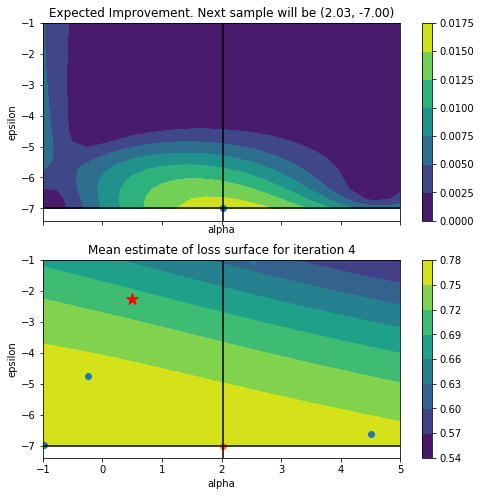

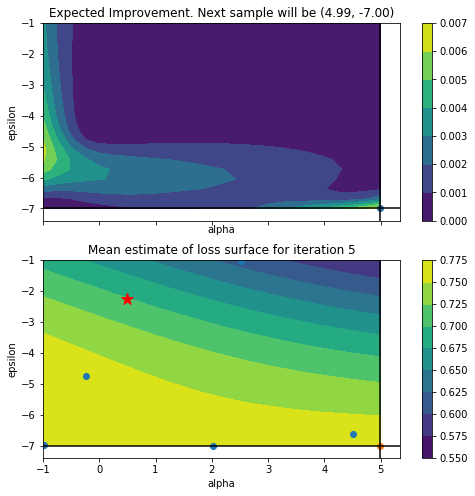

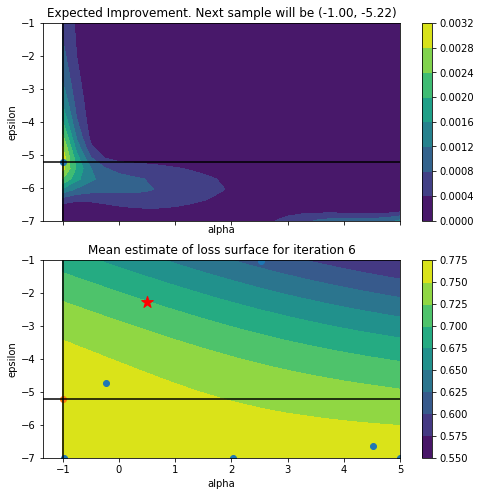

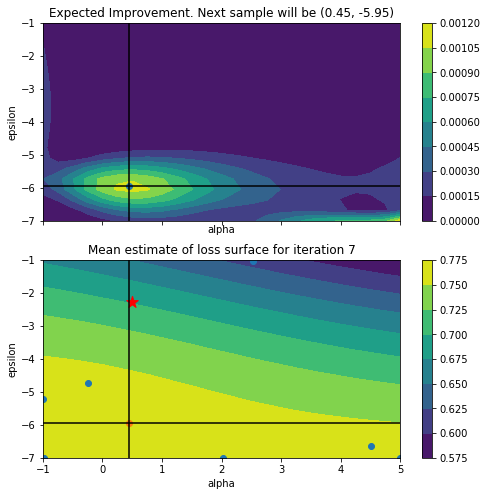

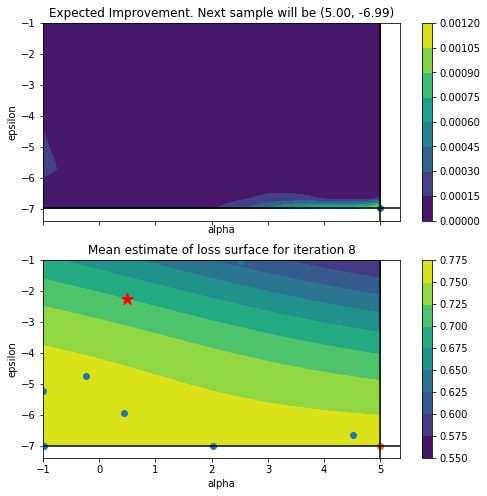

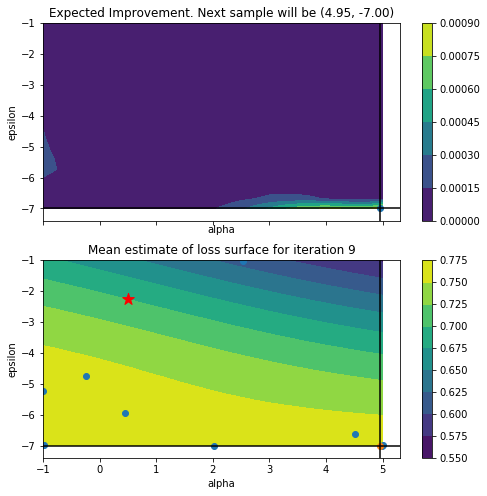

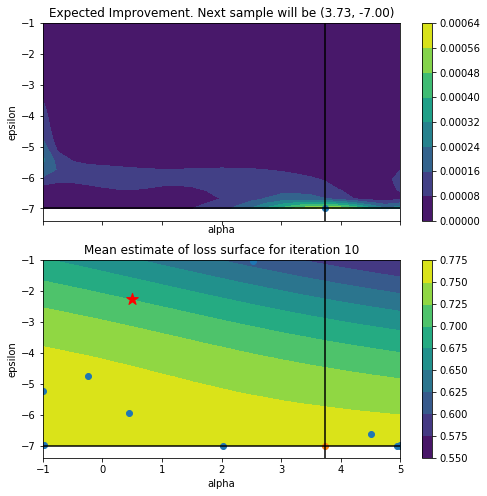

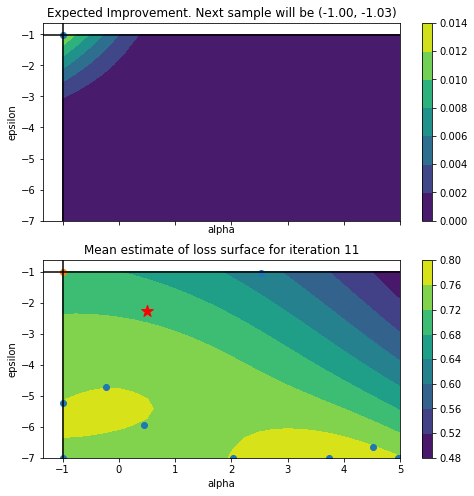

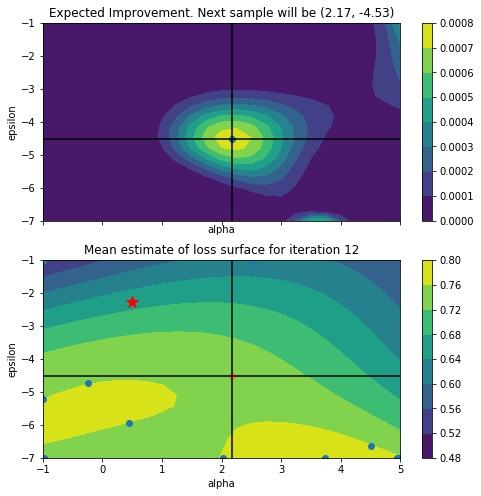

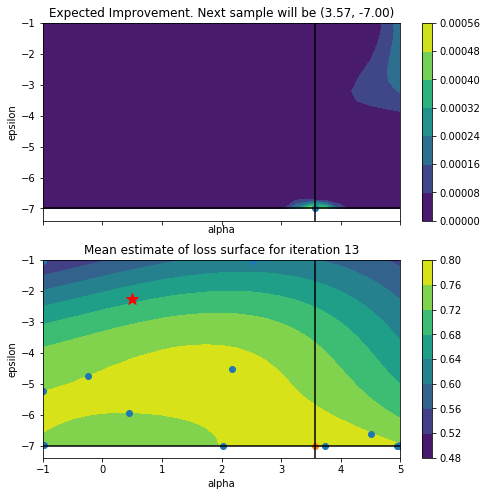

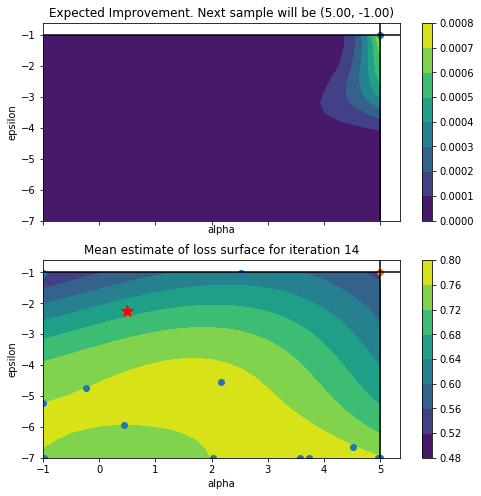

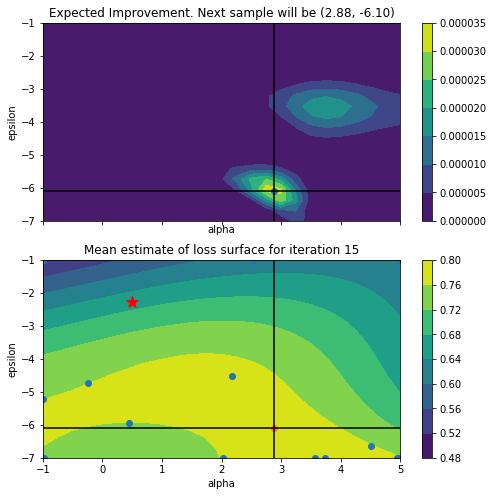

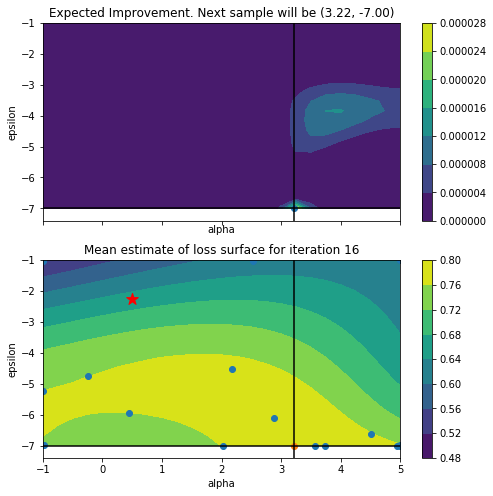

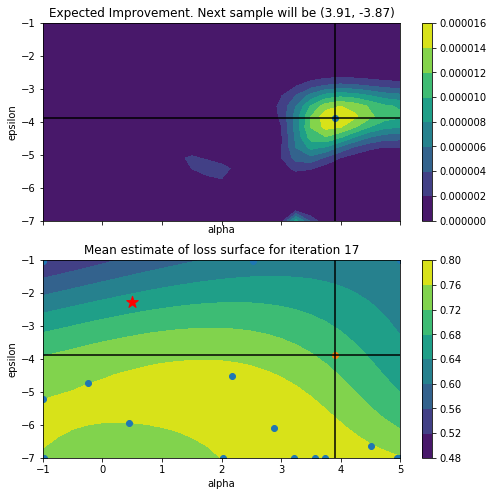

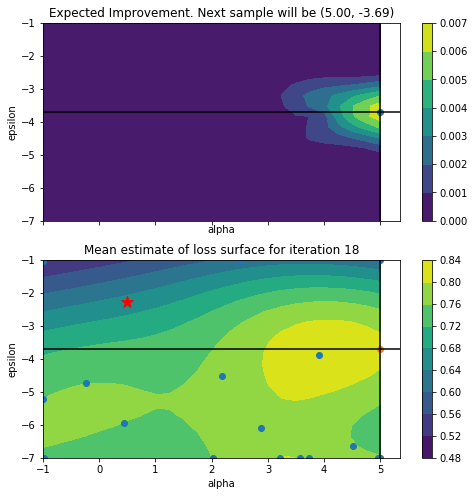

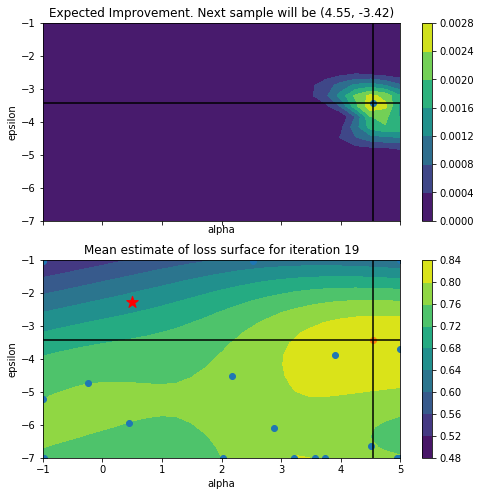

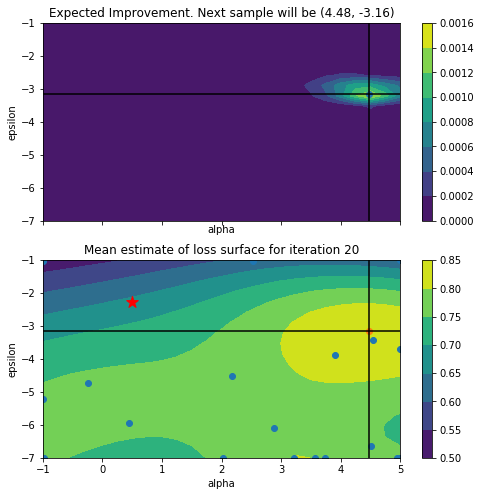

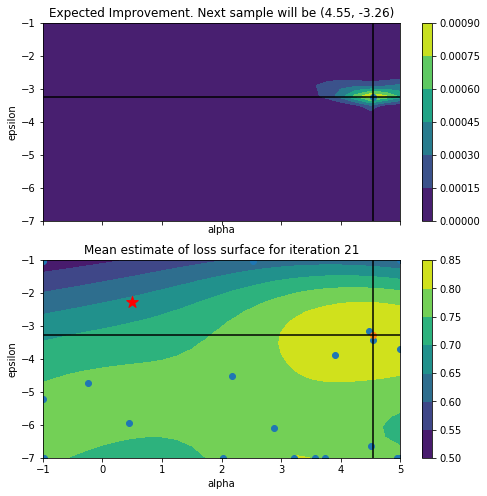

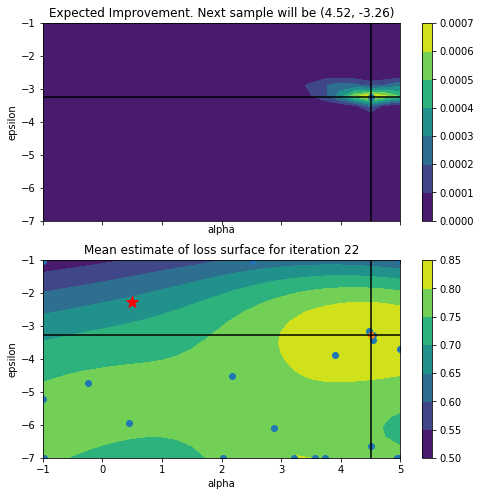

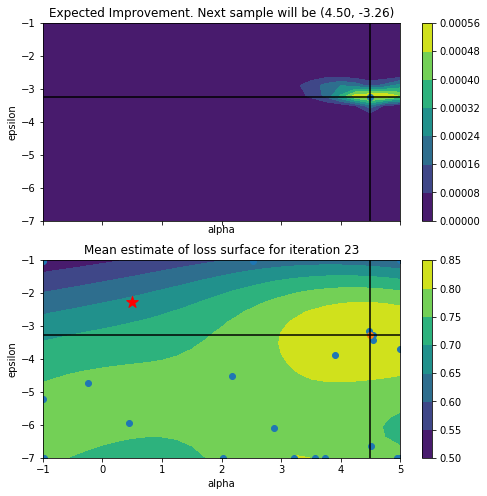

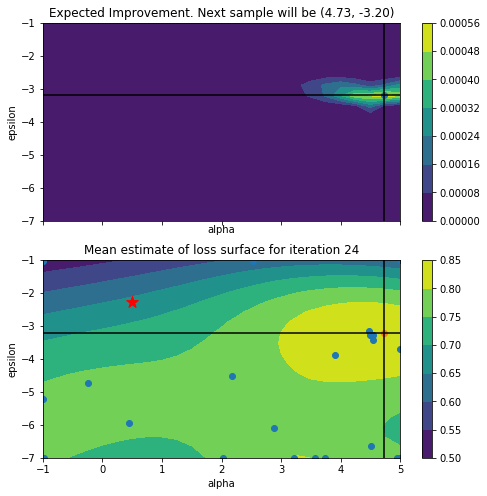

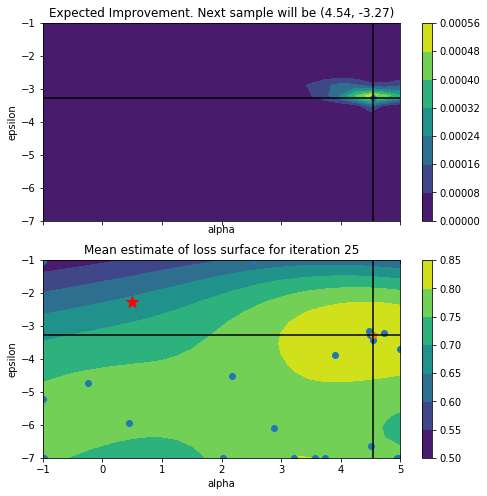

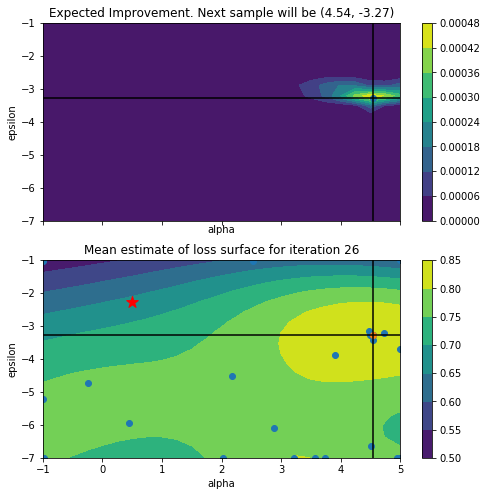

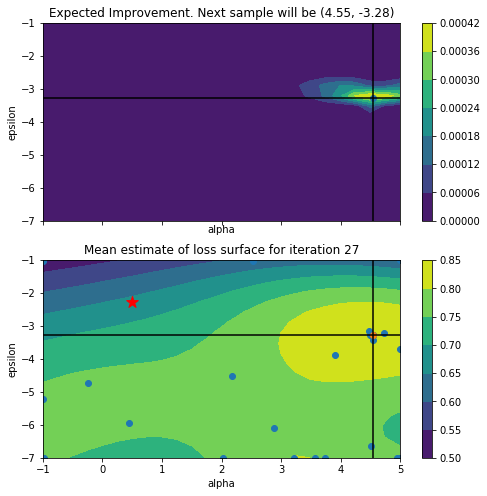

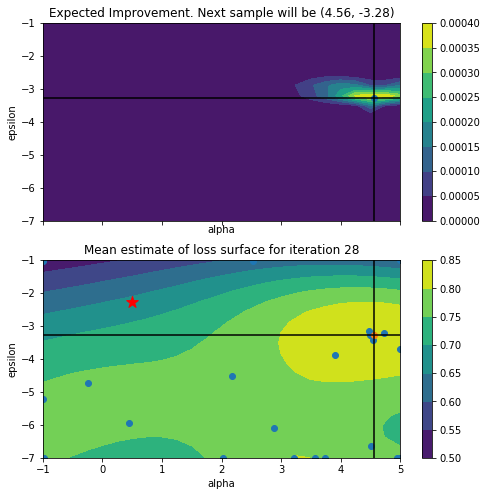

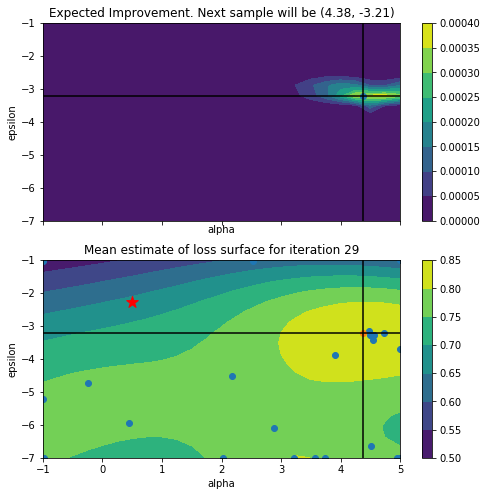

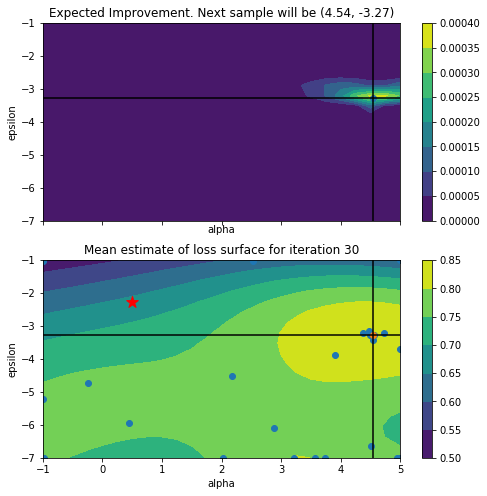

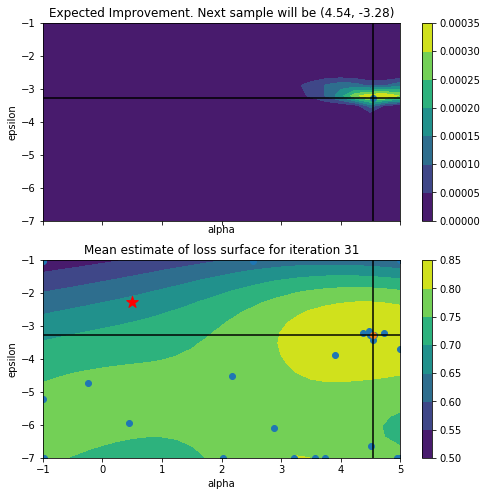

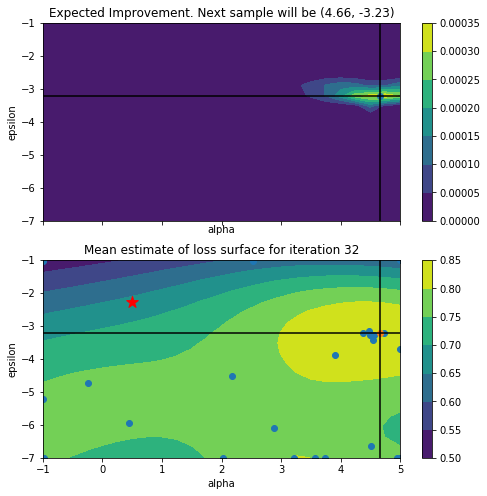

In [17]:
rc('text', usetex=False)

plot_iteration(Cs, xp, yp, first_iter=3, second_param_grid=gammas, optimum=maximum, filepath='.')


Ici nous constatons une bien meilleure convergence de notre algorithme vers la "pseudo valeur optimale". Sur les dernières itérations, il reste dans une zone d'isovaleur fixe ce qui prouve qu'ici la convergence de l'algorithme est efficace.

Par ailleurs nos obtenons bien des valeurs différentes pour nos hyperparamètres car nous travaillons ici sur un échantillon différent.

# Conclusion

Nous avons alors expliqué et implémenté une méthode d'optimisation Bayésienne. Cette dernière nous permet à partir de processus Gaussien d'optimiser intelligement nos hyperparamètres d'algorithmes de machine learning en plusieurs itérations. Cela permettra d'avoir une meilleure précision pour notre algorithme de machine learning puisqu'on attribue à notre modèle des hyperparamètres optimaux propres aux données étudiées. 

Il serait possible de refaire cette même approche pour plus de paramètres pour une fonction de machine learning mais cela serait bien plus compliqué à représenter graphiquement et cela augmenterait grandement le temps de calcul puisqu'il faut faire toutes les combinaisons possibles entre les différents hyperparamètres. C'est pour cela que nous nous sommes limités à l'optimisation de 2 hyperparamètres.

Nous avons obtenu des résultats de convergence peu satisfaisants sur le dataset iris. Il est possible que le faible nombre de valeur de ce dataset (150 valeurs pour 3 classes) ne permette pas d'avoir une optimisation de qualité. De plus il est possible que notre "valeur optimale" (étoile rouge) ne soit pas une bonne valeur vers laquelle converger puisqu'elle dépend du nombre de combinaisons évalué : plus ce nombre est important plus la qualité de cette valeur augmente.

- Changer les noms de variables sur la graphs
- Ajouter des explications un peu partout
- Conclusion générale (A COMPLETER)
- Générer un rapport PDF
- Faire un Read.Me
- Changer lien implémentation
- Partie Linux à ajouter éventuellement